In [1]:
import numpy as np
import mySDC

### Secion 2 Crouseilles Lawson for Dahlquist eq.

$$u_t = \lambda_1u + \lambda_2u \equiv Au + F(u)$$
$$|\lambda_1| >> |\lambda_2|$$

var. change: $$v = e^{-tA}u(t) \equiv e^{-t\lambda_1}u(t) $$

$$v_t = e^{-tA}F(e^{tA}v(t)) \equiv \lambda_2 v(t) = f(v)$$

In [2]:
l1, l2 = -10 + 0.j, -0.03j
t0 = 0.0
u0 = 1.0 + 0.j
steps = 101 # t=0. -> t=1.

t = np.zeros((steps))
timestep = 0.01

u = np.zeros((steps), dtype=np.cfloat)
uv = np.zeros((steps), dtype=np.cfloat)

# var change
v0 = u0 * np.exp(-t0*l1) # === 1.0

# rhs for v
def fv(t, v):
    return l2 * v

# rhs for u
def fu(t, u):
    return (l1 + l2) * u

### Lawson-RK45 and direct RK45

max error Lawson-RK 1.1102251422055052e-16
max error RK 1.2090641662340153e-09


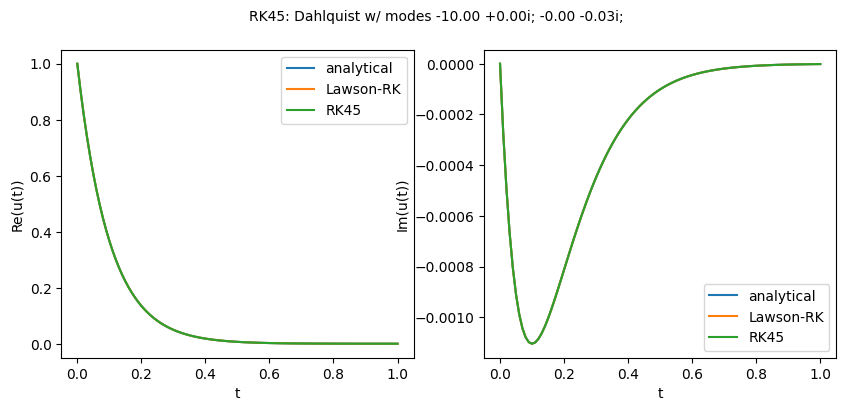

In [3]:
import scipy

# RK45(u) and Lawson-RK45(v) integrators
v_integ = scipy.integrate.RK45(fv, t0, [v0], 100., first_step=timestep, max_step=timestep)
u_integ = scipy.integrate.RK45(fu, t0, [u0], 100., first_step=timestep, max_step=timestep)

for i in range(steps):
    t[i] = v_integ.t
    uv[i] = v_integ.y * (np.exp(v_integ.t*l1) + 0.j)
    v_integ.step()
    u[i] = u_integ.y
    u_integ.step()

print("max error Lawson-RK", np.max(np.abs(uv - np.exp((l1 + l2)*t))))
print("max error RK", np.max(np.abs(u - np.exp((l1 + l2)*t))))

mySDC.plot_solutions("RK45", [l1, l2], ["analytical", "Lawson-RK", "RK45"], [np.exp((l1 + l2)*t), uv, u], t)

### Lawson Euler-SDC (Buvoli 2.2)

max error no sweeps 3.997828659060109e-08
max error 1 sweeps 1.571496871058033e-12
max error 2 sweeps 2.2204471080412447e-16
max error 3 sweeps 2.2204502844110104e-16
max error 4 sweeps 2.2204502844110104e-16
max error 5 sweeps 2.2204502844110104e-16


/opt/homebrew/lib/python3.10/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


max error 6 sweeps 2.2204502844110104e-16


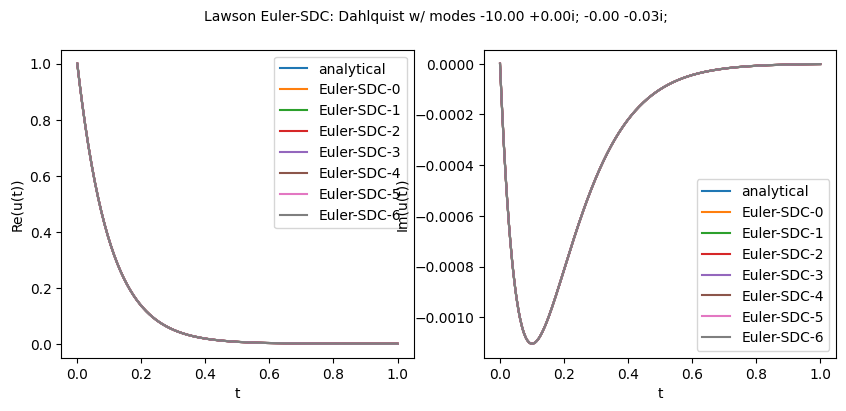

In [4]:
uv0 = u0 # * np.exp(-t0*l1) === 1.0

N = 5

fv = lambda t, x : x * l2

tau, uv_sdc_0 = mySDC.Euler_SDC(N, 0, t, uv0, [fv])
exptl1 = np.exp(tau * l1) + 0.j # Lawson v -> u change of variable
analytical = np.exp((l1 + l2)*tau)

M_max = 7
uv_sdc = [analytical, uv_sdc_0 * exptl1]
plot_names = ["analytical", "Euler-SDC-0"]
print("max error no sweeps", np.max(np.abs(uv_sdc_0 * exptl1 - analytical)))


for M in range(1, M_max):
    _, uv = mySDC.Euler_SDC(N, M, t, uv0, [fv])
    uv_sdc.append(uv * exptl1)
    plot_names.append("Euler-SDC-" + str(M))
    print("max error " + str(M) + " sweeps", np.max(np.abs(uv * exptl1 - analytical)))

# plot solution
mySDC.plot_solutions("Lawson Euler-SDC", [l1, l2], plot_names, uv_sdc, tau)

In [4]:
# error in Lawson vars
print("Lawson Euler SDC: Lawson vars error")
N, folds = 5, 10

uv0 = u0
fv = lambda t, x : x * l2
for M in range(0, 6):
    mySDC.benchmark(mySDC.Euler_SDC, (N, M, t, uv0, [fv]), lambda tt: np.exp(l2 * tt), folds)

Lawson Euler SDC: Lawson vars error
0 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 1.0797e-06 | 12.38
5.0000e-03 | 5.3983e-07 | 6.05
2.5000e-03 | 2.6992e-07 | 7.08
1.2500e-03 | 1.3496e-07 | 12.55
6.2500e-04 | 6.7479e-08 | 26.57
3.1250e-04 | 3.3740e-08 | 46.21
1.5625e-04 | 1.6870e-08 | 80.71
7.8125e-05 | 8.4349e-09 | 166.64
3.9063e-05 | 4.2175e-09 | 337.02
1.9531e-05 | 2.1087e-09 | 650.32
1 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 4.2379e-11 | 15.60
5.0000e-03 | 1.0595e-11 | 22.08
2.5000e-03 | 2.6488e-12 | 44.77
1.2500e-03 | 6.6249e-13 | 85.97


/opt/homebrew/lib/python3.10/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


6.2500e-04 | 1.6660e-13 | 182.17
3.1250e-04 | 4.5595e-14 | 353.88
1.5625e-04 | 8.4803e-15 | 694.01
7.8125e-05 | 1.0122e-14 | 1372.23
3.9063e-05 | 1.4224e-14 | 2739.91
1.9531e-05 | 1.4433e-14 | 5463.43
2 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 5.5540e-15 | 21.07
5.0000e-03 | 1.1102e-15 | 40.27
2.5000e-03 | 2.1095e-15 | 80.10
1.2500e-03 | 1.5545e-15 | 168.51
6.2500e-04 | 1.8878e-15 | 340.88
3.1250e-04 | 1.0214e-14 | 648.49
1.5625e-04 | 6.2173e-15 | 1318.01
7.8125e-05 | 9.4373e-15 | 2592.27
3.9063e-05 | 1.4104e-14 | 5164.20
1.9531e-05 | 1.4445e-14 | 10345.94
3 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 7.7720e-16 | 29.65
5.0000e-03 | 8.8842e-16 | 58.62
2.5000e-03 | 2.2204e-15 | 118.05
1.2500e-03 | 1.5546e-15 | 240.89
6.2500e-04 | 1.8878e-15 | 480.22
3.1250e-04 | 1.0214e-14 | 947.40
1.5625e-04 | 6.2173e-15 | 1898.00
7.8125e-05 | 9.4373e-15 | 3754.66
3.9063e-05 | 1.4104e-14 | 7600.76
1.9531e-05 | 

KeyboardInterrupt: 

max error no sweeps 0.004494433173832417
max error 1 sweeps 5.7860273135477585e-05
max error 2 sweeps 7.920025803753671e-07
max error 3 sweeps 6.336051271454983e-08
max error 4 sweeps 6.514349314712027e-08
max error 5 sweeps 6.511428042655822e-08
max error 6 sweeps 6.511477367624008e-08


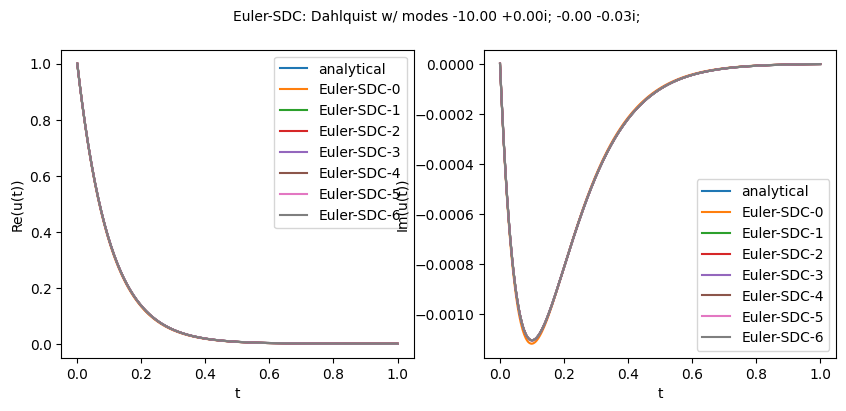

In [6]:
N = 5

def fu(t, u):
    return (l1 + l2) * u

tau, u_sdc_0 = mySDC.Euler_SDC(N, 0, t, u0, [fu])
analytical = np.exp((l1 + l2)*tau)

M_max = 7
u_sdc = [analytical, u_sdc_0]
plot_names = ["analytical", "Euler-SDC-0"]
print("max error no sweeps", np.max(np.abs(u_sdc_0 - analytical)))

for M in range(1, M_max):
    _, u = mySDC.Euler_SDC(N, M, t, u0, [fu])
    u_sdc.append(u)
    plot_names.append("Euler-SDC-" + str(M))
    print("max error " + str(M) + " sweeps", np.max(np.abs(u - analytical)))

# plot solution
mySDC.plot_solutions("Euler-SDC", [l1, l2], plot_names, u_sdc, tau)

In [5]:
print("Euler SDC")
N, folds = 5, 10

fu = lambda t, x : x * (l1 + l2) + 0.j
for M in range(0, 7):
    mySDC.benchmark(mySDC.Euler_SDC, (N, M, t, u0, [fu]), lambda tt: np.exp((l1 + l2) * tt) + 0.j, folds)

Euler SDC
0 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 4.4944e-03 | 10.66
5.0000e-03 | 2.2267e-03 | 8.52
2.5000e-03 | 1.1083e-03 | 6.78
1.2500e-03 | 5.5290e-04 | 14.47
6.2500e-04 | 2.7614e-04 | 29.97
3.1250e-04 | 1.3799e-04 | 43.48
1.5625e-04 | 6.8976e-05 | 82.04
7.8125e-05 | 3.4483e-05 | 167.20
3.9063e-05 | 1.7240e-05 | 342.81
1.9531e-05 | 8.6199e-06 | 673.70
1 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 5.7860e-05 | 11.61
5.0000e-03 | 1.4452e-05 | 24.32
2.5000e-03 | 3.6111e-06 | 43.16
1.2500e-03 | 9.0250e-07 | 85.16
6.2500e-04 | 2.2559e-07 | 180.89
3.1250e-04 | 5.6393e-08 | 355.35
1.5625e-04 | 1.4098e-08 | 694.41
7.8125e-05 | 3.5244e-09 | 1376.83
3.9063e-05 | 8.8108e-10 | 2759.63
1.9531e-05 | 2.2027e-10 | 5735.03
2 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 7.9200e-07 | 21.88
5.0000e-03 | 9.8397e-08 | 41.58
2.5000e-03 | 1.2264e-08 | 85.69
1.2500e-03

### ETD-SDC (Buvoli 2.3)

$$u_t = \lambda_1u + \lambda_2u \equiv \Lambda u + N(u)$$
$$|\lambda_1| >> |\lambda_2|$$

$$\Lambda = \lambda_1; N(\cdot) = \lambda_2*$$

In [5]:
print("ETD SDC")
N, folds = 5, 5

fn = lambda x : x * l2
for M in range(0, 7):
    mySDC.benchmark(mySDC.ETDSDC, (N, M, t, u0, [l1, fn]), lambda tt: np.exp((l1 + l2) * tt), folds)

ETD SDC
0 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 1.3444e-05 | 920.76
5.0000e-03 | 6.6707e-06 | 1778.80
2.5000e-03 | 3.3226e-06 | 3547.29
1.2500e-03 | 1.6581e-06 | 7108.36
6.2500e-04 | 8.2827e-07 | 14189.56
1 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 2.1570e-05 | 890.71
5.0000e-03 | 1.0674e-05 | 1794.18
2.5000e-03 | 5.3099e-06 | 3577.47
1.2500e-03 | 2.6481e-06 | 7118.57
6.2500e-04 | 1.3224e-06 | 14139.65
2 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 2.1570e-05 | 890.61
5.0000e-03 | 1.0674e-05 | 1795.23
2.5000e-03 | 5.3099e-06 | 3576.58
1.2500e-03 | 2.6481e-06 | 7154.06
6.2500e-04 | 1.3224e-06 | 14285.19
3 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 2.1570e-05 | 896.64
5.0000e-03 | 1.0674e-05 | 1789.13
2.5000e-03 | 5.3099e-06 | 3595.27
1.2500e-03 | 2.6481e-06 | 7126.88
6.2500e-04 | 1.3224e-06 | 14424.54


### IMEX-SDC (Buvoli 2.4)

max error no sweeps 4.413027362855691e-05
max error 1 sweeps 5.770048803924276e-09
max error 2 sweeps 8.227075405960957e-13
max error 3 sweeps 4.2910317140546384e-14
max error 4 sweeps 4.285479842404868e-14
max error 5 sweeps 4.2743775322797955e-14
max error 6 sweeps 4.285479842404868e-14


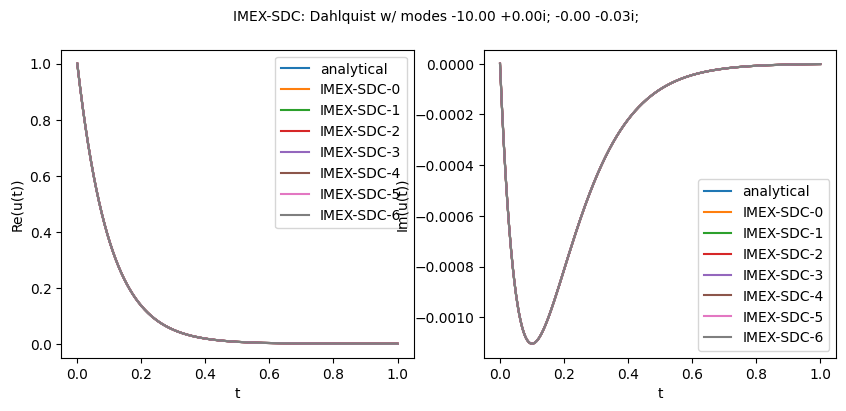

In [8]:
fn = lambda x : x * l2

tau, u_sdc_0 = mySDC.IMEXSDC(N, 0, t, u0, l1, fn)
analytical = np.exp((l1 + l2)*tau)

M_max = 7
u_sdc = [analytical, u_sdc_0]
plot_names = ["analytical", "IMEX-SDC-0"]
print("max error no sweeps", np.max(np.abs(u_sdc_0 - analytical)))

for M in range(1, M_max):
    _, u = mySDC.IMEXSDC(N, M, t, u0, l1, fn)
    u_sdc.append(u)
    plot_names.append("IMEX-SDC-" + str(M))
    print("max error " + str(M) + " sweeps", np.max(np.abs(u - analytical)))

# plot solution
mySDC.plot_solutions("IMEX-SDC", [l1, l2], plot_names, u_sdc, tau)

In [6]:
print("IMEX SDC")
N, folds = 5, 1

fn = lambda x : x * l2
for M in range(0, 7):
    mySDC.benchmark(mySDC.IMEXSDC, (N, M, t, u0, [l1, fn]), lambda tt: np.exp((l1 + l2) * tt), folds)

IMEX SDC
0 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 4.3913e-03 | 4.60
5.0000e-03 | 2.2012e-03 | 16.58
2.5000e-03 | 1.1020e-03 | 11.13
1.2500e-03 | 5.5132e-04 | 21.84
6.2500e-04 | 2.7574e-04 | 38.25
3.1250e-04 | 1.3789e-04 | 56.67
1.5625e-04 | 6.8952e-05 | 113.58
7.8125e-05 | 3.4477e-05 | 226.38
3.9063e-05 | 1.7239e-05 | 458.34
1.9531e-05 | 8.6195e-06 | 913.56
1 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 5.3801e-05 | 12.54
5.0000e-03 | 1.3929e-05 | 24.31
2.5000e-03 | 3.5447e-06 | 49.30
1.2500e-03 | 8.9414e-07 | 97.32
6.2500e-04 | 2.2454e-07 | 200.68
3.1250e-04 | 5.6262e-08 | 395.48
1.5625e-04 | 1.4081e-08 | 797.68
7.8125e-05 | 3.5222e-09 | 1573.12
3.9063e-05 | 8.8080e-10 | 3142.27
1.9531e-05 | 2.2080e-10 | 6257.60
2 sweeps
timestep   |   max(E)   | cpu time [ms]
----------------------------
1.0000e-02 | 6.9748e-07 | 22.64
5.0000e-03 | 9.2265e-08 | 45.06
2.5000e-03 | 1.1874e-08 | 89.99
1.2500e-0